In [2]:
%load_ext autoreload
%autoreload 2

import torch
import numpy as np
import pandas as pd
import sys 
sys.path.append("../../")
from src.model import ddsm as ddsm
from src.model import ddsm_model as modeld
from src.model.lightning_model_diffusion import LightningDiffusion as lightning_dif
import src.utils.sequence as utils

import scipy as sp
from matplotlib import pyplot as plt
%matplotlib inline
import wandb # This is optinal 

/home/ueharam1/miniconda3/envs/GRELU1/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load pre-trained model 

In [3]:
run = wandb.init(entity ='grelu', project="Diffusion-DNA-RNA", name = "test") # Change depending on your proejcts
artifact = run.use_artifact('MPRA-y-HepG2-Unconditional-Model:v0')
dir = artifact.download()
wandb.finish()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: Currently logged in as: uehara-masatoshi (grelu). Use `wandb login --relogin` to force relogin


wandb: Downloading large artifact MPRA-y-HepG2-Unconditional-Model:v0, 152.03MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.2


In [7]:
class ModelParameters:
    diffusion_weights_file = 'artifacts/MPRA-dataset:v2/steps400.cat4.speed_balance.time4.0.samples100000.pth'
    checkpoint_path = 'artifacts/MPRA-y-HepG2-Unconditional-Model:v0/diffusion_epoch=054.ckpt'
    time_schedule = 'artifacts/MPRA-dataset:v2/time_dependent.npz'
config = ModelParameters() 

DEVICE = "cuda:7" # Any number is fine

In [9]:
# Introduce Two Models
score_model = lightning_dif.load_from_checkpoint(checkpoint_path= config.checkpoint_path, weight_file = config.diffusion_weights_file, time_schedule = config.time_schedule, all_class_number =1)
score_model = score_model.model
score_model.cuda(device = DEVICE) 


original_model = lightning_dif.load_from_checkpoint(checkpoint_path= config.checkpoint_path, weight_file = config.diffusion_weights_file, time_schedule = config.time_schedule, all_class_number =1)
original_model = original_model.model
original_model.cuda(device = DEVICE) 

ScoreNet(
  (embed): Sequential(
    (0): GaussianFourierProjection()
    (1): Linear(in_features=256, out_features=256, bias=True)
  )
  (linear): Conv1d(4, 256, kernel_size=(9,), stride=(1,), padding=(4,))
  (blocks): ModuleList(
    (0-1): 2 x Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(4,))
    (2): Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(16,), dilation=(4,))
    (3): Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(64,), dilation=(16,))
    (4): Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(256,), dilation=(64,))
    (5-6): 2 x Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(4,))
    (7): Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(16,), dilation=(4,))
    (8): Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(64,), dilation=(16,))
    (9): Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(256,), dilation=(64,))
    (10-11): 2 x Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(4,))
    (12

In [10]:
# Load Reward model
from grelu.lightning import LightningModel
model = LightningModel.load_from_checkpoint("artifacts/model:v4/model.ckpt")
model.eval()
model.to(DEVICE)

wandb: Currently logged in as: uehara-masatoshi. Use `wandb login --relogin` to force relogin
wandb: Downloading large artifact human_state_dict:latest, 939.29MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.6


LightningModel(
  (model): EnformerPretrainedModel(
    (embedding): EnformerTrunk(
      (conv_tower): EnformerConvTower(
        (blocks): ModuleList(
          (0): Sequential(
            (0): Conv1d(4, 768, kernel_size=(15,), stride=(1,), padding=same)
            (1): ConvBlock(
              (norm): Norm(
                (layer): BatchNorm1d(768, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              )
              (conv): Conv1d(768, 768, kernel_size=(1,), stride=(1,), padding=same)
              (act): Activation(
                (layer): GELU()
              )
              (pool): Pool(
                (layer): AttentionPool(
                  (pool_fn): Rearrange('b d (n p) -> b d n p', p=2)
                  (to_attn_logits): Conv2d(768, 768, kernel_size=(1, 1), stride=(1, 1), bias=False)
                )
              )
              (dropout): Dropout(
                (layer): Identity()
              )
              (channel_transform): ChannelT

In [11]:
def new_reward_model(x):
    x = torch.nn.functional.softmax(x /0.1, -1)
    seq = torch.transpose(x, 1, 2) 
    return model(seq)

In [12]:
from src.model import ddsm_fine_tune  as fine_tune

save_name = "log_MPRA/" # Set by yourself

loss_curves, eval_curves = fine_tune.fine_tuning(score_model, new_reward_model, [new_reward_model], original_model,
            learning_rate =1e-3, num_epoch = 500, length = 50, num_steps = 50, accmu = 4, gradient_start = 45, \
            batch_size = 128, save_name = save_name, entropy_coff = 0.0,  device= DEVICE)

100%|██████████| 50/50 [00:00<00:00, 60.80it/s]


3


100%|██████████| 50/50 [00:01<00:00, 29.44it/s]


0.012184863910079002
[0.012184863910079002]


100%|██████████| 50/50 [00:00<00:00, 75.23it/s]


7


100%|██████████| 50/50 [00:01<00:00, 31.61it/s]


0.02134937420487404
[0.02134937420487404]


100%|██████████| 50/50 [00:00<00:00, 76.75it/s]


11


100%|██████████| 50/50 [00:01<00:00, 31.60it/s]


0.011660255491733551
[0.011660255491733551]


100%|██████████| 50/50 [00:00<00:00, 76.18it/s]


15


100%|██████████| 50/50 [00:01<00:00, 31.89it/s]


0.008165929466485977
[0.008165929466485977]


100%|██████████| 50/50 [00:00<00:00, 76.96it/s]


19


100%|██████████| 50/50 [00:01<00:00, 31.57it/s]


0.042414575815200806
[0.042414575815200806]


100%|██████████| 50/50 [00:00<00:00, 76.57it/s]


23


100%|██████████| 50/50 [00:01<00:00, 31.93it/s]


0.1769084632396698
[0.1769084632396698]


100%|██████████| 50/50 [00:00<00:00, 77.58it/s]


27


100%|██████████| 50/50 [00:01<00:00, 31.77it/s]


0.06696998327970505
[0.06696998327970505]


100%|██████████| 50/50 [00:00<00:00, 76.63it/s]


31


100%|██████████| 50/50 [00:01<00:00, 31.27it/s]


0.4410301446914673
[0.4410301446914673]


100%|██████████| 50/50 [00:00<00:00, 75.46it/s]


35


100%|██████████| 50/50 [00:01<00:00, 31.88it/s]


1.0186374187469482
[1.0186374187469482]


100%|██████████| 50/50 [00:00<00:00, 76.22it/s]


39


100%|██████████| 50/50 [00:01<00:00, 31.59it/s]


1.1362866163253784
[1.1362866163253784]


100%|██████████| 50/50 [00:00<00:00, 76.36it/s]


43


100%|██████████| 50/50 [00:01<00:00, 31.91it/s]


0.8952094316482544
[0.8952094316482544]


100%|██████████| 50/50 [00:00<00:00, 76.14it/s]


47


100%|██████████| 50/50 [00:01<00:00, 31.61it/s]


1.2306444644927979
[1.2306444644927979]


100%|██████████| 50/50 [00:00<00:00, 76.41it/s]


51


100%|██████████| 50/50 [00:01<00:00, 31.91it/s]


1.108329176902771
[1.108329176902771]


100%|██████████| 50/50 [00:00<00:00, 76.87it/s]


55


100%|██████████| 50/50 [00:01<00:00, 31.95it/s]


1.6624717712402344
[1.6624717712402344]


100%|██████████| 50/50 [00:00<00:00, 75.47it/s]


59


100%|██████████| 50/50 [00:01<00:00, 30.79it/s]


1.544348955154419
[1.544348955154419]


100%|██████████| 50/50 [00:00<00:00, 76.51it/s]


63


100%|██████████| 50/50 [00:01<00:00, 31.71it/s]


0.8560582995414734
[0.8560582995414734]


100%|██████████| 50/50 [00:00<00:00, 76.37it/s]


67


100%|██████████| 50/50 [00:01<00:00, 31.74it/s]


1.147329568862915
[1.147329568862915]


100%|██████████| 50/50 [00:00<00:00, 75.92it/s]


71


100%|██████████| 50/50 [00:01<00:00, 32.02it/s]


1.4335039854049683
[1.4335039854049683]


100%|██████████| 50/50 [00:00<00:00, 75.85it/s]


75


100%|██████████| 50/50 [00:01<00:00, 31.58it/s]


1.1603385210037231
[1.1603385210037231]


100%|██████████| 50/50 [00:00<00:00, 76.37it/s]


79


100%|██████████| 50/50 [00:01<00:00, 31.82it/s]


1.3115522861480713
[1.3115522861480713]


100%|██████████| 50/50 [00:00<00:00, 76.08it/s]


83


100%|██████████| 50/50 [00:01<00:00, 31.65it/s]


1.359435796737671
[1.359435796737671]


100%|██████████| 50/50 [00:00<00:00, 77.20it/s]


87


100%|██████████| 50/50 [00:01<00:00, 30.90it/s]


1.5914958715438843
[1.5914958715438843]


100%|██████████| 50/50 [00:00<00:00, 75.80it/s]


91


100%|██████████| 50/50 [00:01<00:00, 31.54it/s]


0.9046334028244019
[0.9046334028244019]


100%|██████████| 50/50 [00:00<00:00, 77.33it/s]


95


100%|██████████| 50/50 [00:01<00:00, 31.79it/s]


1.6604297161102295
[1.6604297161102295]


100%|██████████| 50/50 [00:00<00:00, 77.00it/s]


99


100%|██████████| 50/50 [00:01<00:00, 31.77it/s]


1.576552391052246
[1.576552391052246]


100%|██████████| 50/50 [00:00<00:00, 76.29it/s]


103


100%|██████████| 50/50 [00:01<00:00, 31.89it/s]


1.8864725828170776
[1.8864725828170776]


100%|██████████| 50/50 [00:00<00:00, 77.34it/s]


107


100%|██████████| 50/50 [00:01<00:00, 31.63it/s]


1.5606807470321655
[1.5606807470321655]


100%|██████████| 50/50 [00:00<00:00, 76.19it/s]


111


100%|██████████| 50/50 [00:01<00:00, 31.71it/s]


1.9714816808700562
[1.9714816808700562]


100%|██████████| 50/50 [00:00<00:00, 75.90it/s]


115


100%|██████████| 50/50 [00:01<00:00, 31.34it/s]


1.6568979024887085
[1.6568979024887085]


100%|██████████| 50/50 [00:00<00:00, 75.60it/s]


119


100%|██████████| 50/50 [00:01<00:00, 31.78it/s]


2.054896354675293
[2.054896354675293]


100%|██████████| 50/50 [00:00<00:00, 77.40it/s]


123


100%|██████████| 50/50 [00:01<00:00, 31.40it/s]


2.035646915435791
[2.035646915435791]


100%|██████████| 50/50 [00:00<00:00, 76.46it/s]


127


100%|██████████| 50/50 [00:01<00:00, 32.03it/s]


2.0349345207214355
[2.0349345207214355]


100%|██████████| 50/50 [00:00<00:00, 77.46it/s]


131


100%|██████████| 50/50 [00:01<00:00, 31.91it/s]


2.0604395866394043
[2.0604395866394043]


100%|██████████| 50/50 [00:00<00:00, 76.78it/s]


135


100%|██████████| 50/50 [00:01<00:00, 31.66it/s]


2.026991844177246
[2.026991844177246]


100%|██████████| 50/50 [00:00<00:00, 76.37it/s]


139


100%|██████████| 50/50 [00:01<00:00, 31.80it/s]


2.178400993347168
[2.178400993347168]


100%|██████████| 50/50 [00:00<00:00, 76.51it/s]


143


100%|██████████| 50/50 [00:01<00:00, 31.86it/s]


2.086794376373291
[2.086794376373291]


100%|██████████| 50/50 [00:00<00:00, 77.64it/s]


147


100%|██████████| 50/50 [00:01<00:00, 31.76it/s]


2.1443729400634766
[2.1443729400634766]


100%|██████████| 50/50 [00:00<00:00, 77.73it/s]


151


100%|██████████| 50/50 [00:01<00:00, 31.79it/s]


2.143010139465332
[2.143010139465332]


100%|██████████| 50/50 [00:00<00:00, 75.87it/s]


155


100%|██████████| 50/50 [00:01<00:00, 31.89it/s]


2.1885218620300293
[2.1885218620300293]


100%|██████████| 50/50 [00:00<00:00, 76.75it/s]


159


100%|██████████| 50/50 [00:01<00:00, 31.91it/s]


2.0414204597473145
[2.0414204597473145]


100%|██████████| 50/50 [00:00<00:00, 76.88it/s]


163


100%|██████████| 50/50 [00:01<00:00, 31.92it/s]


2.185713529586792
[2.185713529586792]


100%|██████████| 50/50 [00:00<00:00, 76.85it/s]


167


100%|██████████| 50/50 [00:01<00:00, 31.74it/s]


2.069967746734619
[2.069967746734619]


100%|██████████| 50/50 [00:00<00:00, 77.49it/s]


171


100%|██████████| 50/50 [00:01<00:00, 31.70it/s]


2.1567015647888184
[2.1567015647888184]


100%|██████████| 50/50 [00:00<00:00, 76.67it/s]


175


100%|██████████| 50/50 [00:01<00:00, 30.13it/s]


2.248650550842285
[2.248650550842285]


100%|██████████| 50/50 [00:00<00:00, 54.08it/s]


179


100%|██████████| 50/50 [00:02<00:00, 23.19it/s]


1.9721214771270752
[1.9721214771270752]


100%|██████████| 50/50 [00:00<00:00, 54.46it/s]


183


100%|██████████| 50/50 [00:01<00:00, 30.62it/s]


2.183983325958252
[2.183983325958252]


100%|██████████| 50/50 [00:00<00:00, 55.51it/s]


187


100%|██████████| 50/50 [00:02<00:00, 23.14it/s]


2.172459602355957
[2.172459602355957]


100%|██████████| 50/50 [00:00<00:00, 64.40it/s]


191


100%|██████████| 50/50 [00:01<00:00, 31.79it/s]


2.226710081100464
[2.226710081100464]


100%|██████████| 50/50 [00:00<00:00, 75.97it/s]


195


100%|██████████| 50/50 [00:01<00:00, 31.63it/s]


1.7064074277877808
[1.7064074277877808]


100%|██████████| 50/50 [00:00<00:00, 63.46it/s]


199


100%|██████████| 50/50 [00:01<00:00, 31.99it/s]


2.2176921367645264
[2.2176921367645264]


100%|██████████| 50/50 [00:00<00:00, 76.62it/s]


203


100%|██████████| 50/50 [00:01<00:00, 31.79it/s]


2.1511850357055664
[2.1511850357055664]


100%|██████████| 50/50 [00:00<00:00, 76.53it/s]


207


100%|██████████| 50/50 [00:01<00:00, 31.48it/s]


2.2073116302490234
[2.2073116302490234]


100%|██████████| 50/50 [00:00<00:00, 76.53it/s]


211


100%|██████████| 50/50 [00:01<00:00, 31.76it/s]


2.2314705848693848
[2.2314705848693848]


100%|██████████| 50/50 [00:00<00:00, 76.04it/s]


215


100%|██████████| 50/50 [00:01<00:00, 31.80it/s]


1.7110459804534912
[1.7110459804534912]


100%|██████████| 50/50 [00:00<00:00, 77.51it/s]


219


100%|██████████| 50/50 [00:01<00:00, 31.97it/s]


2.260268211364746
[2.260268211364746]


100%|██████████| 50/50 [00:00<00:00, 77.02it/s]


223


100%|██████████| 50/50 [00:01<00:00, 31.82it/s]


2.057424306869507
[2.057424306869507]


100%|██████████| 50/50 [00:00<00:00, 61.56it/s]


227


100%|██████████| 50/50 [00:01<00:00, 31.92it/s]


2.2576904296875
[2.2576904296875]


100%|██████████| 50/50 [00:00<00:00, 77.07it/s]


231


100%|██████████| 50/50 [00:01<00:00, 31.81it/s]


2.2195987701416016
[2.2195987701416016]


100%|██████████| 50/50 [00:00<00:00, 77.04it/s]


235


100%|██████████| 50/50 [00:01<00:00, 31.87it/s]


2.269145965576172
[2.269145965576172]


100%|██████████| 50/50 [00:00<00:00, 76.58it/s]


239


100%|██████████| 50/50 [00:01<00:00, 31.68it/s]


2.231393337249756
[2.231393337249756]


100%|██████████| 50/50 [00:00<00:00, 77.41it/s]


243


100%|██████████| 50/50 [00:01<00:00, 31.67it/s]


2.2486138343811035
[2.2486138343811035]


100%|██████████| 50/50 [00:00<00:00, 77.35it/s]


247


100%|██████████| 50/50 [00:01<00:00, 31.84it/s]


2.2816085815429688
[2.2816085815429688]


100%|██████████| 50/50 [00:00<00:00, 77.17it/s]


251


100%|██████████| 50/50 [00:01<00:00, 31.75it/s]


2.2916407585144043
[2.2916407585144043]


100%|██████████| 50/50 [00:00<00:00, 76.91it/s]


255


100%|██████████| 50/50 [00:01<00:00, 31.80it/s]


2.302278518676758
[2.302278518676758]


100%|██████████| 50/50 [00:00<00:00, 76.54it/s]


259


100%|██████████| 50/50 [00:01<00:00, 31.97it/s]


2.2767081260681152
[2.2767081260681152]


100%|██████████| 50/50 [00:00<00:00, 76.28it/s]


263


100%|██████████| 50/50 [00:01<00:00, 31.84it/s]


2.0166263580322266
[2.0166263580322266]


100%|██████████| 50/50 [00:00<00:00, 74.73it/s]


267


100%|██████████| 50/50 [00:01<00:00, 31.79it/s]


2.2825582027435303
[2.2825582027435303]


100%|██████████| 50/50 [00:00<00:00, 77.27it/s]


271


100%|██████████| 50/50 [00:01<00:00, 31.84it/s]


2.2577617168426514
[2.2577617168426514]


100%|██████████| 50/50 [00:00<00:00, 77.01it/s]


275


100%|██████████| 50/50 [00:01<00:00, 31.92it/s]


2.2082414627075195
[2.2082414627075195]


100%|██████████| 50/50 [00:00<00:00, 77.27it/s]


279


100%|██████████| 50/50 [00:01<00:00, 32.06it/s]


2.2953786849975586
[2.2953786849975586]


100%|██████████| 50/50 [00:00<00:00, 76.53it/s]


283


100%|██████████| 50/50 [00:01<00:00, 32.07it/s]


2.271601676940918
[2.271601676940918]


100%|██████████| 50/50 [00:00<00:00, 69.61it/s]


287


100%|██████████| 50/50 [00:01<00:00, 31.38it/s]


2.2735798358917236
[2.2735798358917236]


100%|██████████| 50/50 [00:00<00:00, 76.61it/s]


291


100%|██████████| 50/50 [00:01<00:00, 31.84it/s]


2.2855124473571777
[2.2855124473571777]


100%|██████████| 50/50 [00:00<00:00, 76.33it/s]


295


100%|██████████| 50/50 [00:01<00:00, 32.10it/s]


2.2565038204193115
[2.2565038204193115]


100%|██████████| 50/50 [00:00<00:00, 76.73it/s]


299


100%|██████████| 50/50 [00:01<00:00, 31.87it/s]


2.327226161956787
[2.327226161956787]


100%|██████████| 50/50 [00:00<00:00, 77.18it/s]


303


100%|██████████| 50/50 [00:01<00:00, 31.72it/s]


2.2991890907287598
[2.2991890907287598]


100%|██████████| 50/50 [00:00<00:00, 76.46it/s]


307


100%|██████████| 50/50 [00:01<00:00, 31.72it/s]


1.7079639434814453
[1.7079639434814453]


100%|██████████| 50/50 [00:00<00:00, 76.73it/s]


311


100%|██████████| 50/50 [00:01<00:00, 31.64it/s]


2.3073267936706543
[2.3073267936706543]


100%|██████████| 50/50 [00:00<00:00, 61.92it/s]


315


100%|██████████| 50/50 [00:01<00:00, 31.66it/s]


2.316077709197998
[2.316077709197998]


100%|██████████| 50/50 [00:00<00:00, 76.66it/s]


319


100%|██████████| 50/50 [00:01<00:00, 31.92it/s]


2.317251205444336
[2.317251205444336]


100%|██████████| 50/50 [00:00<00:00, 76.80it/s]


323


100%|██████████| 50/50 [00:01<00:00, 31.97it/s]


2.220399856567383
[2.220399856567383]


100%|██████████| 50/50 [00:00<00:00, 76.90it/s]


327


100%|██████████| 50/50 [00:01<00:00, 31.79it/s]


2.2846429347991943
[2.2846429347991943]


100%|██████████| 50/50 [00:00<00:00, 76.51it/s]


331


100%|██████████| 50/50 [00:01<00:00, 31.73it/s]


2.1394283771514893
[2.1394283771514893]


100%|██████████| 50/50 [00:00<00:00, 75.49it/s]


335


100%|██████████| 50/50 [00:01<00:00, 31.80it/s]


2.2639453411102295
[2.2639453411102295]


100%|██████████| 50/50 [00:00<00:00, 77.21it/s]


339


100%|██████████| 50/50 [00:01<00:00, 31.89it/s]


2.3275108337402344
[2.3275108337402344]


100%|██████████| 50/50 [00:00<00:00, 58.45it/s]


343


100%|██████████| 50/50 [00:01<00:00, 31.98it/s]


2.352077007293701
[2.352077007293701]


100%|██████████| 50/50 [00:00<00:00, 76.31it/s]


347


100%|██████████| 50/50 [00:01<00:00, 31.95it/s]


2.3501510620117188
[2.3501510620117188]


100%|██████████| 50/50 [00:00<00:00, 77.13it/s]


351


100%|██████████| 50/50 [00:01<00:00, 31.95it/s]


2.3105216026306152
[2.3105216026306152]


100%|██████████| 50/50 [00:00<00:00, 76.98it/s]


355


100%|██████████| 50/50 [00:01<00:00, 31.79it/s]


2.3372206687927246
[2.3372206687927246]


100%|██████████| 50/50 [00:00<00:00, 76.69it/s]


359


100%|██████████| 50/50 [00:01<00:00, 31.79it/s]


2.349719524383545
[2.349719524383545]


100%|██████████| 50/50 [00:00<00:00, 76.00it/s]


363


100%|██████████| 50/50 [00:01<00:00, 31.83it/s]


2.272366523742676
[2.272366523742676]


100%|██████████| 50/50 [00:00<00:00, 75.91it/s]


367


100%|██████████| 50/50 [00:01<00:00, 31.89it/s]


2.333244800567627
[2.333244800567627]


100%|██████████| 50/50 [00:00<00:00, 75.91it/s]


371


100%|██████████| 50/50 [00:01<00:00, 32.02it/s]


2.359389066696167
[2.359389066696167]


100%|██████████| 50/50 [00:00<00:00, 76.20it/s]


375


100%|██████████| 50/50 [00:01<00:00, 31.80it/s]


2.356471061706543
[2.356471061706543]


100%|██████████| 50/50 [00:00<00:00, 76.42it/s]


379


100%|██████████| 50/50 [00:01<00:00, 31.94it/s]


2.127683401107788
[2.127683401107788]


100%|██████████| 50/50 [00:00<00:00, 76.56it/s]


383


100%|██████████| 50/50 [00:01<00:00, 31.74it/s]


2.3215324878692627
[2.3215324878692627]


100%|██████████| 50/50 [00:00<00:00, 76.67it/s]


387


100%|██████████| 50/50 [00:01<00:00, 31.57it/s]


2.36747145652771
[2.36747145652771]


100%|██████████| 50/50 [00:00<00:00, 77.20it/s]


391


100%|██████████| 50/50 [00:01<00:00, 31.47it/s]


2.3683128356933594
[2.3683128356933594]


100%|██████████| 50/50 [00:00<00:00, 77.44it/s]


395


100%|██████████| 50/50 [00:01<00:00, 31.89it/s]


2.3931708335876465
[2.3931708335876465]


100%|██████████| 50/50 [00:00<00:00, 76.38it/s]


399


100%|██████████| 50/50 [00:01<00:00, 31.95it/s]


2.4029712677001953
[2.4029712677001953]


100%|██████████| 50/50 [00:00<00:00, 77.36it/s]


403


100%|██████████| 50/50 [00:01<00:00, 31.80it/s]


2.3582711219787598
[2.3582711219787598]


100%|██████████| 50/50 [00:00<00:00, 76.95it/s]


407


100%|██████████| 50/50 [00:01<00:00, 31.96it/s]


2.3999524116516113
[2.3999524116516113]


100%|██████████| 50/50 [00:00<00:00, 76.75it/s]


411


100%|██████████| 50/50 [00:01<00:00, 31.94it/s]


2.2993316650390625
[2.2993316650390625]


100%|██████████| 50/50 [00:00<00:00, 77.18it/s]


415


100%|██████████| 50/50 [00:01<00:00, 31.85it/s]


2.4396681785583496
[2.4396681785583496]


100%|██████████| 50/50 [00:00<00:00, 75.39it/s]


419


100%|██████████| 50/50 [00:01<00:00, 31.69it/s]


2.417789936065674
[2.417789936065674]


100%|██████████| 50/50 [00:00<00:00, 76.81it/s]


423


100%|██████████| 50/50 [00:01<00:00, 31.96it/s]


2.4266297817230225
[2.4266297817230225]


100%|██████████| 50/50 [00:00<00:00, 76.53it/s]


427


100%|██████████| 50/50 [00:01<00:00, 32.00it/s]


2.2546167373657227
[2.2546167373657227]


100%|██████████| 50/50 [00:00<00:00, 74.53it/s]


431


100%|██████████| 50/50 [00:01<00:00, 31.96it/s]


2.4228134155273438
[2.4228134155273438]


100%|██████████| 50/50 [00:00<00:00, 76.35it/s]


435


100%|██████████| 50/50 [00:01<00:00, 31.86it/s]


2.4396166801452637
[2.4396166801452637]


100%|██████████| 50/50 [00:00<00:00, 76.69it/s]


439


100%|██████████| 50/50 [00:01<00:00, 31.57it/s]


1.8708064556121826
[1.8708064556121826]


100%|██████████| 50/50 [00:00<00:00, 76.54it/s]


443


100%|██████████| 50/50 [00:01<00:00, 31.86it/s]


2.4653584957122803
[2.4653584957122803]


100%|██████████| 50/50 [00:00<00:00, 76.97it/s]


447


100%|██████████| 50/50 [00:01<00:00, 31.67it/s]


2.4318861961364746
[2.4318861961364746]


100%|██████████| 50/50 [00:00<00:00, 77.14it/s]


451


100%|██████████| 50/50 [00:01<00:00, 31.99it/s]


2.448341131210327
[2.448341131210327]


100%|██████████| 50/50 [00:00<00:00, 76.49it/s]


455


100%|██████████| 50/50 [00:01<00:00, 31.86it/s]


2.1782665252685547
[2.1782665252685547]


100%|██████████| 50/50 [00:00<00:00, 76.58it/s]


459


100%|██████████| 50/50 [00:01<00:00, 31.80it/s]


2.4549367427825928
[2.4549367427825928]


100%|██████████| 50/50 [00:00<00:00, 75.91it/s]


463


100%|██████████| 50/50 [00:01<00:00, 31.99it/s]


2.385099411010742
[2.385099411010742]


100%|██████████| 50/50 [00:00<00:00, 75.39it/s]


KeyboardInterrupt: 

# Evaluation 

In [13]:
#### Load Fine-Tuned Model 
time_dependent_weights = torch.tensor(np.load(config.time_schedule)['x'])
score_finetuned_model = modeld.ScoreNet(time_dependent_weights=torch.sqrt(time_dependent_weights)) 
score_finetuned_model.load_state_dict(torch.load("log_MPRA/_459.pth")) # Change here
score_finetuned_model.cuda(device = DEVICE) 


ScoreNet(
  (embed): Sequential(
    (0): GaussianFourierProjection()
    (1): Linear(in_features=256, out_features=256, bias=True)
  )
  (linear): Conv1d(4, 256, kernel_size=(9,), stride=(1,), padding=(4,))
  (blocks): ModuleList(
    (0-1): 2 x Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(4,))
    (2): Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(16,), dilation=(4,))
    (3): Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(64,), dilation=(16,))
    (4): Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(256,), dilation=(64,))
    (5-6): 2 x Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(4,))
    (7): Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(16,), dilation=(4,))
    (8): Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(64,), dilation=(16,))
    (9): Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(256,), dilation=(64,))
    (10-11): 2 x Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(4,))
    (12

In [14]:
### Get Samples after Fine-tune models 

sampler = ddsm.Euler_Maruyama_sampler


allsamples_original = []
for t in range(5):
    samples=[]
    score_finetuned_model.eval()
    samples.append(sampler(score_finetuned_model,
                        (50,4),
                        batch_size=128,
                        new_class = None,
                        class_number = 1,
                        strength = 10, 
                        max_time=  4.0,
                        min_time= 1.0/400,
                        time_dilation=1,
                        num_steps=100, 
                        eps=1e-5,
                        speed_balanced= True,
                        device= DEVICE, 
                        ).cpu().detach().numpy())
    allsamples_original.append(samples)

100%|██████████| 100/100 [00:01<00:00, 81.51it/s]


In [15]:
allsamples = np.concatenate(allsamples_original, axis=1)
allsamples = allsamples[0,:,:,:]

generated_samples = []
data_loader = torch.utils.data.DataLoader(allsamples.astype("float32"), batch_size = 128 , num_workers=0)
for batch in data_loader:
    batch = (batch > 0.5) * torch.ones_like(batch)
    batch = torch.permute(batch, (0, 2, 1)).to(DEVICE)
    generated_samples.append(model(batch).detach().cpu() ) 

generated_samples = np.concatenate(generated_samples)

In [16]:
### Get Samples from Pre-Trained Models 

sampler = ddsm.Euler_Maruyama_sampler

allsamples_original = []
for t in range(5):
    samples=[]
    score_model.eval()
    samples.append(sampler(original_model,
                        (50,4),
                        batch_size=128,
                        new_class = None,
                        class_number = 1,
                        strength = 10, 
                        max_time=  4.0,
                        min_time= 1.0/400,
                        time_dilation=1,
                        num_steps=100, 
                        eps=1e-5,
                        speed_balanced= True,
                        device= DEVICE, 
                        ).cpu().detach().numpy())
    allsamples_original.append(samples)

100%|██████████| 100/100 [00:01<00:00, 80.12it/s]


In [17]:
allsamples = np.concatenate(allsamples_original, axis=1)
allsamples = allsamples[0,:,:,:]

In [18]:
generated_samples_before = []
data_loader = torch.utils.data.DataLoader(allsamples.astype("float32"), batch_size = 128 , num_workers=0)
for batch in data_loader:
    batch = (batch > 0.5) * torch.ones_like(batch)
    batch = torch.permute(batch, (0, 2, 1)).to(DEVICE)
    generated_samples_before.append( model(batch).detach().cpu() ) 

generated_samples_before = np.concatenate(generated_samples_before)

<Figure size 8000x1000 with 0 Axes>

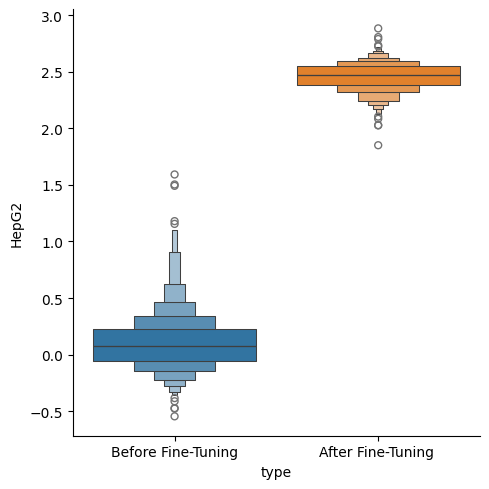

In [19]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(80, 10))

compare = np.concatenate( (generated_samples_before[:,0], generated_samples[:,0]  ), axis= 0)

type1 = ['Before Fine-Tuning' for i in range(len(generated_samples_before[:,0] ))]
#type2 = ['Generated (Strong Sig)' for i in range(len(generated_samples[:,0] ))]
type3 = ['After Fine-Tuning ' for i in range(len(generated_samples[:,0]))]

type =   type1 +  type3
data_dict = {'type': type, 'HepG2': compare[:,0] }
plot_data = pd.DataFrame(data_dict)
fig = sns.catplot(data=plot_data, x = 'type', y =  'HepG2', hue="type", kind="boxen" )
sns.set_context("paper", rc={"figure.figsize": (80, 10)})
#fig.savefig("../media/RNA_output_high.png")



